In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
import gradio as gr
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\fergb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
games_df = pd.read_csv('games.csv')
games_details_df = pd.read_csv('games_details.csv')
players_df = pd.read_csv('players.csv')
ranking_df = pd.read_csv('ranking.csv')
teams_df = pd.read_csv('teams.csv')

C:\Users\fergb\AppData\Local\Temp\ipykernel_16704\2321718875.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  games_details_df = pd.read_csv('games_details.csv')


### Preparing the Data

In [3]:
games_details_df = games_details_df[games_details_df['COMMENT'].isna()]

games_details_df["PLUS_MINUS"] = games_details_df['PLUS_MINUS'].replace(np.nan, 0)

games_df = games_df.dropna()

game_dropped_columns = ["GAME_DATE_EST", "GAME_ID" , "GAME_STATUS_TEXT", "HOME_TEAM_ID", "VISITOR_TEAM_ID"]
details_dropped_columns = ["GAME_ID","TEAM_ID","TEAM_ABBREVIATION","TEAM_CITY","PLAYER_ID","PLAYER_NAME","NICKNAME","START_POSITION", 'COMMENT']
stats = ['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PTS','PLUS_MINUS']

In [4]:
team_ids = teams_df['TEAM_ID'].unique()

In [5]:
def min_to_float(min):
    if (type(min) == str):
        if (':' in min):
            if ("." in min):
                split = min.split('.')
                min = ":".join([split[0], split[1][-2:]])
            mins, secs = map(int, min.split(':'))
            return (mins + secs) / 60.0
        else:
            return float(min)
    return min

games_details_df["MIN"] = games_details_df["MIN"].apply(min_to_float)

### Prediction Functionality

In [6]:
def get_team_id(name):
    return teams_df[teams_df['NICKNAME'] == name]['TEAM_ID'].values[0]

In [7]:
def predict_classifer(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X,              
                                                    y,              
                                                    test_size=0.2,  
                                                    random_state=20,
                                                    stratify=y
                                                   )
    c = KNeighborsClassifier()
    c.fit(X_train, y_train)

    return c.predict(X_test)

In [8]:
def predict_regressor(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X,              
                                                    y,              
                                                    test_size=0.2,  
                                                    random_state=20,
                                                   )
    r = RandomForestRegressor(random_state=7)
    r.fit(X_train, y_train)

    return r.predict(X_test)

In [9]:
def predict_winner(home, away):
    X = games_df[(games_df["HOME_TEAM_ID"] == get_team_id(home)) & (games_df['VISITOR_TEAM_ID'] == get_team_id(away))]
    X = X.drop(columns=game_dropped_columns)
    y = X['HOME_TEAM_WINS']
    X = X.drop(columns='HOME_TEAM_WINS')
    
    predictions = predict_classifer(X, y)

    result = np.bincount(predictions).argmax()
    
    return result == 1

In [10]:
def predict_score(home, away):
    X = games_df[(games_df["HOME_TEAM_ID"] == get_team_id(home)) & (games_df['VISITOR_TEAM_ID'] == get_team_id(away))]
    X = X.drop(columns=game_dropped_columns)
    y = X[['PTS_home', 'PTS_away']]
    X = X.drop(columns=['PTS_home', 'PTS_away'])

    predictions = predict_regressor(X, y)

    home_scores = predictions[:, 0]
    away_scores = predictions[:, 1]

    return (math.floor(np.mean(home_scores)), math.floor(np.mean(away_scores)))

In [11]:
def predict_player_stat_against_team(player, team, stat):
    games_played_by_player = games_details_df[games_details_df['PLAYER_NAME'] == player]
    game_ids = games_played_by_player['GAME_ID'].tolist()
    
    games_ids_against_team = []
    for game_id in game_ids:
        game = games_df[games_df['GAME_ID'] == game_id]
        if (game["HOME_TEAM_ID"].values[0] == get_team_id(team) or game["VISITOR_TEAM_ID"].values[0] == get_team_id(team)):
            games_ids_against_team.append(game_id)

    games_against_team = games_played_by_player[games_played_by_player['GAME_ID'].isin(games_ids_against_team)]
    X = games_against_team.drop(columns=details_dropped_columns)
    y = X[stat]
    X = X.drop(columns=stat)

    predictions = predict_regressor(X, y)

    return math.floor(np.mean(predictions))

### Betting Functionality

In [12]:
def betting_number(pred, bet, is_betting_over):
     return (is_betting_over and bet < pred) or (not is_betting_over and bet > pred)

In [13]:
def make_win_bet(home, away, is_home_winning):
    pred = predict_winner(home, away)
    return is_home_winning == pred

In [14]:
def make_score_bet(home, away, bet, is_betting_home, is_betting_over):
    pred = predict_score(home, away)
    if (is_betting_home):
        return betting_number(pred[0], bet, is_betting_over), pred[0]
    else:
        return betting_number(pred[1], bet, is_betting_over), pred[1]

In [15]:
def make_player_stat_bet(player, stat, bet, opponent, is_beating_over):
    pred = predict_player_stat_against_team(player, opponent, stat)
    return betting_number(pred, bet, is_beating_over), pred

In [16]:
win_iface = gr.Interface(
    fn=make_win_bet,
    inputs=[
        gr.Textbox("", label="Home Team"),
        gr.Textbox("", label="Away Team"),
        gr.Checkbox(label="Is Home Winning?")
    ],
    outputs=gr.Textbox(label='Correct'),
    theme="compact",
    title="Winning Bet Predictor"
)

win_iface.launch()

C:\Users\fergb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\gradio\blocks.py:528: UserWarning: Cannot load compact. Caught Exception: The space compact does not exist
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [17]:
score_iface = gr.Interface(
    fn=make_score_bet,
    inputs=[
        gr.Textbox("", label="Home Team"),
        gr.Textbox("", label="Away Team"),
        gr.Number(label='Bet'),
        gr.Checkbox(label="Betting home team?"),
        gr.Checkbox(label='Betting Over?')
    ],
    outputs=[
        gr.Textbox(label='Correct'),
        gr.Textbox(label='Prediction')
    ],
    theme="compact",
    title="Score Bet Predictor"
)

score_iface.launch()

C:\Users\fergb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\gradio\blocks.py:528: UserWarning: Cannot load compact. Caught Exception: The space compact does not exist
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [18]:
stat_iface = gr.Interface(
    fn=make_player_stat_bet,
    inputs=[
        gr.Textbox("", label="Player"),
        gr.Textbox("", label='Stat'),
        gr.Number(label='Bet'),
        gr.Textbox("", label='Opponent'),
        gr.Checkbox(label='Betting Over?')
    ],
    outputs=[
        gr.Textbox(label='Correct'),
        gr.Textbox(label='Prediction')
    ],
    theme="compact",
    title="Stat Bet Predictor"
)

stat_iface.launch()

C:\Users\fergb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\gradio\blocks.py:528: UserWarning: Cannot load compact. Caught Exception: The space compact does not exist
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


### Data Visualization

Text(0.5, 1.0, 'Home Games Played Per Team')

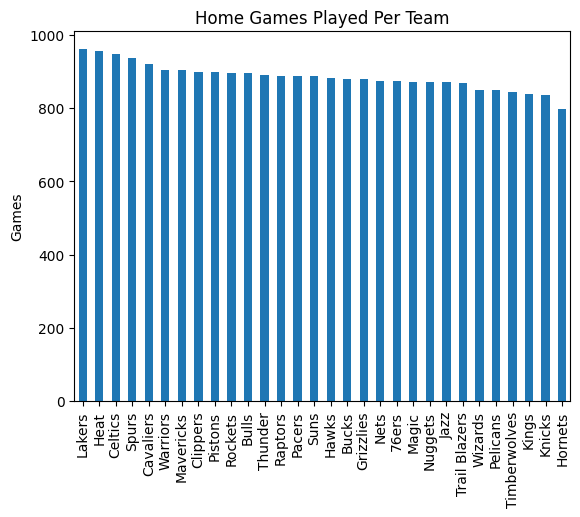

In [19]:
def team_id_to_name(id):
    team = teams_df[teams_df['TEAM_ID'] == id]
    return team['NICKNAME'].values[0]

home_team_counts = games_df['HOME_TEAM_ID'].value_counts()

home_team_names = []
for team_id in home_team_counts.index:
    team_name = team_id_to_name(team_id)
    home_team_names.append(team_name)

home_team_counts = home_team_counts.set_axis(home_team_names)
home_team_counts.plot(kind='bar')
plt.ylabel('Games')
plt.title('Home Games Played Per Team')

Text(0.5, 1.0, 'Away Games Played Per Team')

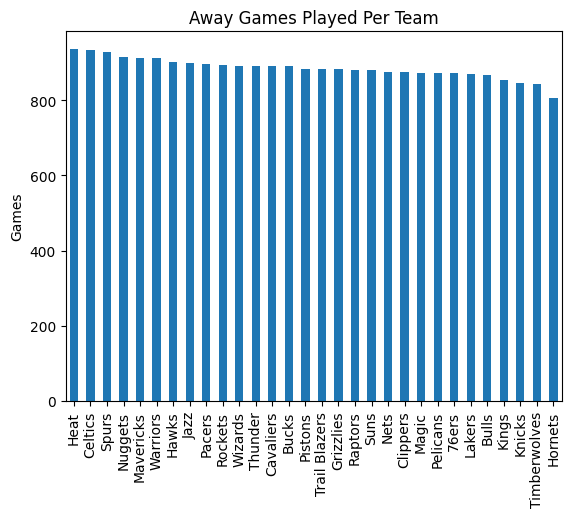

In [20]:
away_team_counts = games_df['VISITOR_TEAM_ID'].value_counts()

away_team_names = []
for team_id in away_team_counts.index:
    team_name = team_id_to_name(team_id)
    away_team_names.append(team_name)

away_team_counts = away_team_counts.set_axis(away_team_names)
away_team_counts.plot(kind='bar')
plt.ylabel('Games')
plt.title('Away Games Played Per Team')

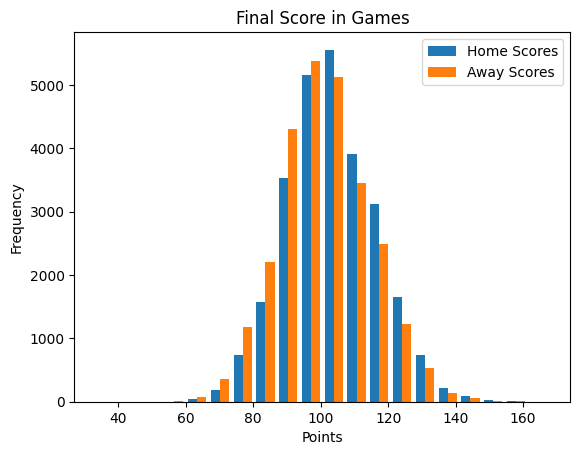

In [45]:
scores = [games_df['PTS_home'], games_df['PTS_away']]
labels = ['Home Scores', 'Away Scores']
plt.hist(scores, bins=20, label=labels)
plt.ylabel('Frequency')
plt.xlabel('Points')
plt.title('Final Score in Games')
plt.legend()

Text(0.5, 1.0, 'Top 10 Most Played Games by Players')

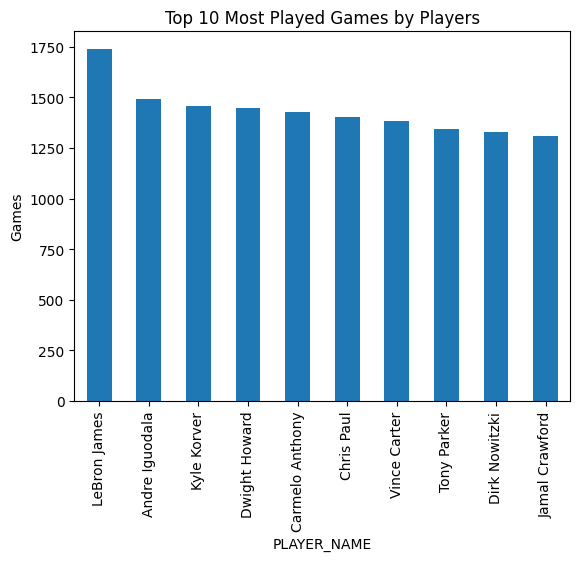

In [21]:
player_counts = games_details_df['PLAYER_NAME'].value_counts()

player_counts.head(10).plot(kind='bar')
plt.ylabel('Games')
plt.title('Top 10 Most Played Games by Players')

Text(0.5, 1.0, 'Points Scored in Games')

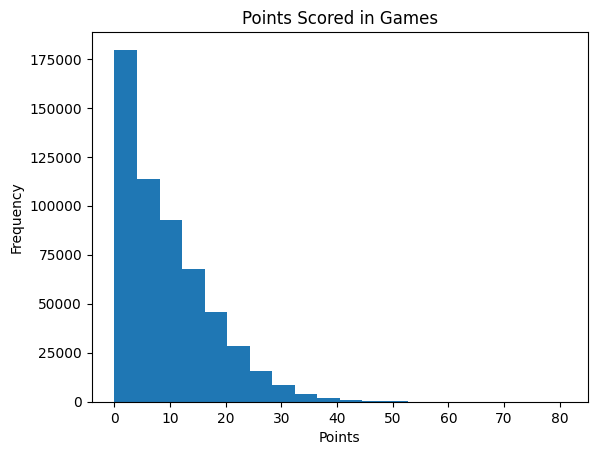

In [22]:
points = games_details_df['PTS']
plt.hist(points, bins=20)
plt.ylabel('Frequency')
plt.xlabel('Points')
plt.title('Points Scored in Games')

Text(0.5, 1.0, 'Assists in Games')

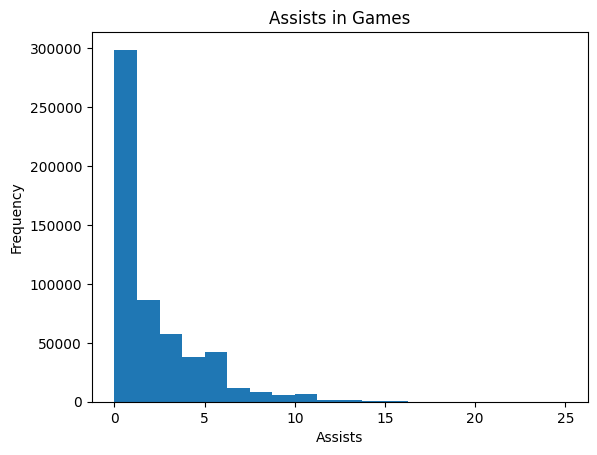

In [23]:
assits = games_details_df['AST']
plt.hist(assits, bins=20)
plt.ylabel('Frequency')
plt.xlabel('Assists')
plt.title('Assists in Games')

Text(0.5, 1.0, 'Rebounds in Games')

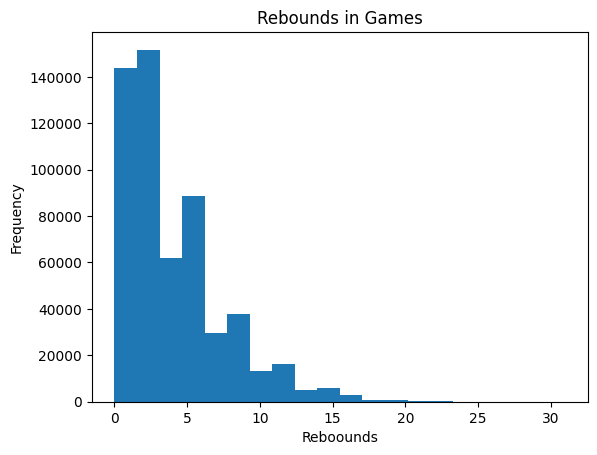

In [24]:
rebs = games_details_df['REB']
plt.hist(rebs, bins=20)
plt.ylabel('Frequency')
plt.xlabel('Reboounds')
plt.title('Rebounds in Games')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'Spurs'),
  Text(1, 0, 'Heat'),
  Text(2, 0, 'Celtics'),
  Text(3, 0, 'Mavericks'),
  Text(4, 0, 'Warriors'),
  Text(5, 0, 'Rockets'),
  Text(6, 0, 'Nuggets'),
  Text(7, 0, 'Jazz'),
  Text(8, 0, 'Lakers'),
  Text(9, 0, 'Thunder'),
  Text(10, 0, 'Cavaliers'),
  Text(11, 0, 'Pacers'),
  Text(12, 0, 'Clippers'),
  Text(13, 0, 'Suns'),
  Text(14, 0, 'Raptors'),
  Text(15, 0, 'Grizzlies'),
  Text(16, 0, 'Bulls'),
  Text(17, 0, 'Trail Blazers'),
  Text(18, 0, 'Bucks'),
  Text(19, 0, 'Pistons'),
  Text(20, 0, 'Hawks'),
  Text(21, 0, '76ers'),
  Text(22, 0, 'Pelicans'),
  Text(23, 0, 'Nets'),
  Text(24, 0, 'Magic'),
  Text(25, 0, 'Wizards'),
  Text(26, 0, 'Kings'),
  Text(27, 0, 'Knicks'),
  Text(28, 0, 'Timberwolves'),
  Text(29, 0, 'Hornets')])

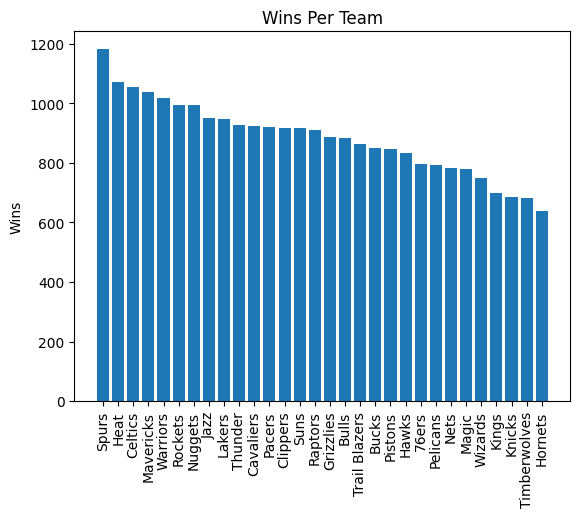

In [25]:
wins_per_team = {}
for team_id in teams_df['TEAM_ID']:
    team_name = team_id_to_name(team_id)
    wins_per_team[team_name] = 0

for index, game in games_df.iterrows():
    home_team = game['HOME_TEAM_ID']
    away_team = game['VISITOR_TEAM_ID']
    if (game['HOME_TEAM_WINS'] == 1):
        wins_per_team[team_id_to_name(home_team)] += 1
    else:
        wins_per_team[team_id_to_name(away_team)] += 1

wins_per_team = dict(sorted(wins_per_team.items(), key=lambda item: item[1], reverse=True))
plt.bar(data=wins_per_team, x=wins_per_team.keys(), height=wins_per_team.values())
plt.title('Wins Per Team')
plt.ylabel('Wins')
plt.xticks(rotation=90)

### Model Analysis

In [26]:
rfc_scores = []
dtc_scores = []
knnc_scores = []

for home_team in team_ids:
    for away_team in team_ids:
        if (home_team != away_team):
            home_vs_away = games_df[(games_df['HOME_TEAM_ID'] == home_team) & (games_df['VISITOR_TEAM_ID'] == away_team)]
            X = home_vs_away.drop(columns=game_dropped_columns)
            X = X.drop(columns='HOME_TEAM_WINS')
            y = home_vs_away['HOME_TEAM_WINS']

            X_train, X_test, y_train, y_test = train_test_split(X,              
                                                y,              
                                                test_size=0.2,  
                                                random_state=20,
                                                stratify=y
                                                )
            
            rfc = RandomForestClassifier(random_state=20)
            rfc.fit(X_train, y_train)

            rfc_scores.append(accuracy_score(rfc.predict(X_test), y_test))

            dtc = DecisionTreeClassifier(random_state=20)
            dtc.fit(X_train, y_train)

            dtc_scores.append(accuracy_score(dtc.predict(X_test), y_test))

            knnc = KNeighborsClassifier()
            knnc.fit(X_train, y_train)

            knnc_scores.append(accuracy_score(knnc.predict(X_test), y_test))

print({'RFC Score' : np.mean(rfc_scores), 'DTC Score' : np.mean(dtc_scores), 'KNNC Score' : np.mean(knnc_scores)})

{'RFC Score': 0.7896859972722042, 'DTC Score': 0.7068373420959627, 'KNNC Score': 0.8302713378575448}


In [32]:
rfr_scores = []
dtr_scores = []
knnr_scores = []

for home_team in team_ids:
    for away_team in team_ids:
        if (home_team != away_team):
            home_vs_away = games_df[(games_df['HOME_TEAM_ID'] == home_team) & (games_df['VISITOR_TEAM_ID'] == away_team)]
            X = home_vs_away.drop(columns=game_dropped_columns)
            X = X.drop(columns=['PTS_home', 'PTS_away'])
            y = home_vs_away[['PTS_home', 'PTS_away']]

            X_train, X_test, y_train, y_test = train_test_split(X,              
                                                y,              
                                                test_size=0.2,  
                                                random_state=20,

                                                )
            
            rfr = RandomForestRegressor(random_state=20)
            rfr.fit(X_train, y_train)

            rfr_scores.append(r2_score(y_pred=rfr.predict(X_test), y_true=y_test))

            dtr = DecisionTreeRegressor(random_state=20)
            dtr.fit(X_train, y_train)

            dtr_scores.append(r2_score(y_pred=dtr.predict(X_test), y_true=y_test))

            knnr = KNeighborsRegressor()
            knnr.fit(X_train, y_train)

            knnr_scores.append(r2_score(y_pred=knnr.predict(X_test), y_true=y_test))

print({'RFR Score' : np.mean(rfr_scores), 'DTR Score' : np.mean(dtr_scores), 'KNNR Score' : np.mean(knnr_scores)})

{'RFR Score': -0.045601593041019746, 'DTR Score': -1.3446374268439427, 'KNNR Score': -0.3988673231849335}


Text(0.5, 0, 'R^2')

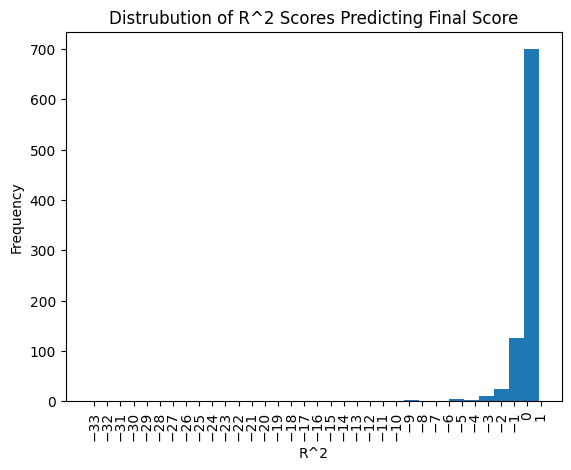

In [34]:
plt.hist(rfr_scores, bins=30)
plt.xticks(np.arange(math.ceil(min(rfr_scores)), math.ceil(max(rfr_scores)+1), 1), rotation=90)
plt.title('Distrubution of R^2 Scores Predicting Final Score')
plt.ylabel('Frequency')
plt.xlabel('R^2')

In [29]:
rfr_scores = []
dtr_scores = []
knnr_scores = []

player_ids = games_details_df['PLAYER_ID'].value_counts().head(10).index
for player in player_ids:
    games_played_by_player = games_details_df[games_details_df['PLAYER_ID'] == player]
    for stat in stats:
        X = games_played_by_player.drop(columns=details_dropped_columns)
        y = X[stat]
        X = X.drop(columns=stat)


        X_train, X_test, y_train, y_test = train_test_split(X,              
                                                    y,              
                                                    test_size=0.2,  
                                                    random_state=20,
                                                    )
                
        rfr = RandomForestRegressor(random_state=20)
        rfr.fit(X_train, y_train)

        rfr_scores.append(r2_score(y_pred=rfr.predict(X_test), y_true=y_test))

        dtr = DecisionTreeRegressor(random_state=20)
        dtr.fit(X_train, y_train)

        dtr_scores.append(r2_score(y_pred=dtr.predict(X_test), y_true=y_test))

        knnr = KNeighborsRegressor()
        knnr.fit(X_train, y_train)

        knnr_scores.append(r2_score(y_pred=knnr.predict(X_test), y_true=y_test))

print({'RFR Score' : np.mean(rfr_scores), 'DTR Score' : np.mean(dtr_scores), 'KNNR Score' : np.mean(knnr_scores)})

{'RFR Score': 0.7150967079845036, 'DTR Score': 0.43609633739327414, 'KNNR Score': 0.3763936285930833}
